In [0]:
!pip install qiskit

     |████████████████████████████████| 6.7MB 2.7MB/s 
     |████████████████████████████████| 23.4MB 93kB/s 
     |████████████████████████████████| 163kB 48.2MB/s 
     |████████████████████████████████| 174kB 48.7MB/s 
     |████████████████████████████████| 1.9MB 34.3MB/s 
     |████████████████████████████████| 51kB 7.1MB/s 
     |████████████████████████████████| 51kB 8.3MB/s 
     |████████████████████████████████| 5.6MB 46.3MB/s 
     |████████████████████████████████| 768kB 48.5MB/s 
     |████████████████████████████████| 296kB 40.1MB/s 
     |████████████████████████████████| 71kB 9.2MB/s 
     |████████████████████████████████| 573kB 48.6MB/s 
     |████████████████████████████████| 26.0MB 1.3MB/s 
     |████████████████████████████████| 2.7MB 47.5MB/s 
  Created wheel for qiskit: filename=qiskit-0.19.2-cp36-none-any.whl size=2896 sha256=6e88e65fdd5c958cb078dde12116c007e4af16ac805e6d3276f08ed1ce0d6777
  Stored in directory: /root/.cache/pip/wheels/d8/29/6e/e065f721b42fe7049

In [0]:
import numpy as np
import torch
from torch.autograd import Function
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F
import torchvision
from torchvision import datasets, transforms
from qiskit import QuantumRegister, QuantumCircuit, ClassicalRegister, execute
from qiskit.circuit import Parameter
from qiskit import Aer
from matplotlib import pyplot as plt
%matplotlib inline

In [0]:
def to_numbers(tensor_list):
    num_list = []
    for tensor in tensor_list:
        num_list += [tensor.item()]
    return num_list

In [0]:
class QiskitCircuit():
    def __init__(self,shots):
        self.theta = Parameter('Theta')
        self.shots = shots
        
        def create_circuit():
            ckt = QuantumCircuit(1,1)
            ckt.h(0)
            ckt.barrier()
            ckt.ry(self.theta,0)
            ckt.barrier()
            ckt.measure(0,0)
            return ckt
        
        self.circuit = create_circuit()
        
    def N_qubit_expectation_Z(self, counts, shots, nr_qubits):
        expects = np.zeros(nr_qubits)
        for key in counts.keys():
            perc = counts[key]/shots
            check = np.array([(float(key[i])-1/2)*2*perc for i in range(nr_qubits)])
            expects += check   
        return expects    
    
    def bind(self, parameters):
        [self.theta] = to_numbers(parameters)
        self.circuit.data[2][0]._params = to_numbers(parameters)
    
    def run(self, i):
        self.bind(i)
        backend = Aer.get_backend('qasm_simulator')
        job_sim = execute(self.circuit,backend,shots=self.shots)
        result_sim = job_sim.result()
        counts = result_sim.get_counts(self.circuit)
        return self.N_qubit_expectation_Z(counts,self.shots,1)

In [0]:
class TorchCircuit(Function):    
    @staticmethod
    def forward(ctx, i):
        if not hasattr(ctx, 'QiskitCirc'):
            ctx.QiskitCirc = QiskitCircuit(shots=100)
            
        exp_value = ctx.QiskitCirc.run(i[0])
        
        result = torch.tensor([exp_value])
        
        ctx.save_for_backward(result, i)
        
        return result
    
    @staticmethod
    def backward(ctx, grad_output):
        s = np.pi/2
        
        forward_tensor, i = ctx.saved_tensors  
        
        input_numbers = to_numbers(i[0])
        
        gradient = []
        
        for k in range(len(input_numbers)):
            input_plus_s = input_numbers
            input_plus_s[k] = input_numbers[k] + s 
            
            exp_value_plus = ctx.QiskitCirc.run(torch.tensor(input_plus_s))[0]
            result_plus_s = torch.tensor([exp_value_plus])
            
            input_minus_s = input_numbers
            input_minus_s[k] = input_numbers[k] - s 
            
            exp_value_minus = ctx.QiskitCirc.run(torch.tensor(input_minus_s))[0]
            result_minus_s = torch.tensor([exp_value_minus])

            gradient_result = (result_plus_s - result_minus_s)

            gradient.append(gradient_result)
            
        result = torch.tensor([gradient])
        
        return result.float() * grad_output.float()

In [0]:
transform = torchvision.transforms.Compose([torchvision.transforms.ToTensor()])
mnist_trainset = datasets.MNIST(root='./data', train=True, download=True, transform=transform)

labels = mnist_trainset.targets 
labels = labels.numpy()

idx1 = np.where(labels == 0)
idx2 = np.where(labels == 1) 

n=100

idx = np.concatenate((idx1[0][0:n],idx2[0][0:n])) 

mnist_trainset.targets = labels[idx] 
mnist_trainset.data = mnist_trainset.data[idx]

train_loader = torch.utils.data.DataLoader(mnist_trainset, batch_size=1, shuffle=True)

Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw


Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw


Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw





Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw
Processing...
Done!


/pytorch/torch/csrc/utils/tensor_numpy.cpp:141: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program.


torch.Size([1, 1, 28, 28]) tensor([1])


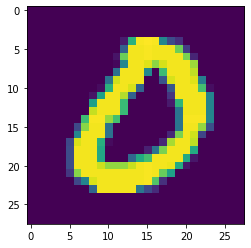

In [0]:
for i in train_loader:
  plt.imshow(i[0][0,0,:,:])
  break


for batch_idx, (data, target) in enumerate(train_loader):
  print(np.shape(data),target)
  break

In [0]:
qc = TorchCircuit.apply 

class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 10, kernel_size=5)
        self.conv2 = nn.Conv2d(10, 20, kernel_size=5)
        self.conv2_drop = nn.Dropout2d()
        self.h1 = nn.Linear(320, 50)
        self.h2 = nn.Linear(50, 1)

    def forward(self, x):
        x = F.relu(F.max_pool2d(self.conv1(x), 2))
        x = F.relu(F.max_pool2d(self.conv2_drop(self.conv2(x)), 2))
        x = x.view(-1, 320)
        #print(np.shape(x))
        x = F.relu(self.h1(x))
        x = F.dropout(x, training=self.training)
        x = self.h2(x)
        #print(x,end=' ')
        x = qc(x)
        #print(x)
        x = (x+1)/2  
        x = torch.cat((x, 1-x), -1)
        return x

In [0]:
network = Net()
optimizer = optim.Adam(network.parameters(), lr=0.001)

epochs = 1
loss_list = []
for epoch in range(epochs):
    total_loss = []
    target_list = []
    for batch_idx, (data, target) in enumerate(train_loader):
        target_list.append(target.item())
        optimizer.zero_grad()
        output = network(data)
        loss = F.nll_loss(output, target)
        loss.backward()
        optimizer.step()
        total_loss.append(loss.item())
    loss_list.append(sum(total_loss)/len(total_loss))
    print(loss_list[-1],end=' ')

for i in range(len(loss_list)):
    loss_list[i] += 1

-0.7038000000000001 

Text(0, 0.5, 'Loss')

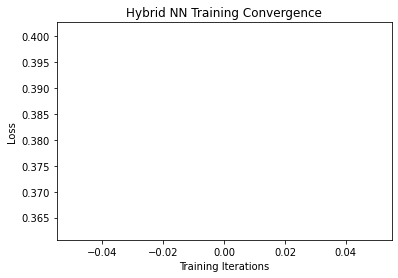

In [0]:
plt.plot(loss_list)
plt.title("Hybrid NN Training Convergence")
plt.xlabel('Training Iterations')
plt.ylabel('Loss')